In [63]:
import joblib
import os
import pandas as pd
import pandas_ta as ta
import numpy as np
import polars as pl
from pathlib import Path
import sys
import datetime
import numpy as np


## **Carga de Datos Inicial**
## **División Entrenamiento/Prueba (Temporal)**
## **Remuestreo de velas**

In [ ]:
BASE_PATH = Path("src")
DATA_FILE = BASE_PATH / "eurusd_5s_2021_2025_07_18utc.parquet"
def block_1_load_data():
    print(">>> [BLOQUE 1] Carga de Datos 5s...")
    if not DATA_FILE.exists(): raise FileNotFoundError(f"No se encuentra {DATA_FILE}")
    df = pl.scan_parquet(str(DATA_FILE)).filter((pl.col("ts").dt.time() >= pl.time(7,0,0)) & (pl.col("ts").dt.time() <= pl.time(18,0,0))).sort("ts").collect()
    print(f"Dataset shape: {df.shape}")
    print("✅ [BLOQUE 1] PASS")
    return df
df_5s = block_1_load_data()
def block_2_split_train_test(df_5s: pl.DataFrame):
    print("\n>>> [BLOQUE 2] Split Train/Test...")
    split_date = datetime.date(2025, 7, 1)
    df_train = df_5s.filter(pl.col("ts").dt.date() < split_date)
    df_test = df_5s.filter(pl.col("ts").dt.date() >= split_date)
    print(f"Train Shape: {df_train.shape}, Test Shape: {df_test.shape}")
    if df_train.height == 0 or df_test.height == 0: raise ValueError("Empty split")
    print("✅ [BLOQUE 2] PASS")
    return df_train, df_test
df_train, df_test = block_2_split_train_test(df_5s)
def resample_ohlcv_microstructure(df_5s, every, ts_col="ts"):
    df_5s = df_5s.sort(ts_col)
    return df_5s.group_by_dynamic(ts_col, every=every, closed="left", label="left", start_by="window").agg([
        pl.col("open").first().alias("open"), pl.col("high").max().alias("high"), pl.col("low").min().alias("low"), pl.col("close").last().alias("close"),
        pl.col("ticks").sum().alias("ticks"), pl.col("bid_vol_sum").sum().alias("bid_vol_sum"), pl.col("ask_vol_sum").sum().alias("ask_vol_sum"),
        pl.col("bid_last").last().alias("bid_last"), pl.col("ask_last").last().alias("ask_last"),
        pl.len().alias("n_bars_5s")
    ]).sort(ts_col)
def block_3_resample(df_train, df_test):
    print("\n>>> [BLOQUE 3] Resample M3...")
    df_train_m3 = resample_ohlcv_microstructure(df_train, "3m")
    df_test_m3 = resample_ohlcv_microstructure(df_test, "3m")
    print(f"Train M3: {df_train_m3.shape}, Test M3: {df_test_m3.shape}")
    print("✅ [BLOQUE 3] PASS")
    return df_train_m3, df_test_m3
df_train_m3, df_test_m3 = block_3_resample(df_train, df_test)


>>> [BLOQUE 1] Carga de Datos 5s...
Dataset shape: (8449570, 10)
✅ [BLOQUE 1] PASS

>>> [BLOQUE 2] Split Train/Test...
Train Shape: (7718101, 10), Test Shape: (731469, 10)
✅ [BLOQUE 2] PASS

>>> [BLOQUE 3] Resample M3...
Train M3: (233418, 11), Test M3: (23339, 11)
✅ [BLOQUE 3] PASS


# Etiqueta

In [ ]:
path_trades='train_results_M3_final.csv'
df_trades_pl = pl.read_csv(path_trades)
df_trades_pl = df_trades_pl.filter(pl.col('signal') == -1)
time_cols = ['signal_ts', 'entry_ts_real', 'exit_price_ts']
for col in time_cols:
    df_trades_pl = df_trades_pl.with_columns(pl.col(col).str.to_datetime().cast(pl.Datetime('ms')))
keep_cols = [
    'signal_ts', 
    'target_15p', 
    'pnl_pips_net', 
    'mae_pips', 
    'mfe_pips', 
    'exit_reason'
]
df_ml_labels = (
    df_trades_pl
    .filter(pl.col('entry_allowed') == True)
    .select(keep_cols)
    .drop_nulls(subset=['target_15p'])
    .with_columns(pl.col('target_15p').cast(pl.Int8))
)
print('Trades Shape (Longs):', df_ml_labels.shape)
print(df_ml_labels.head())
df_ml_labels.schema


Trades Shape (Longs): (1674, 6)
shape: (5, 6)
┌─────────────────────┬────────────┬──────────────┬──────────┬──────────┬─────────────┐
│ signal_ts           ┆ target_15p ┆ pnl_pips_net ┆ mae_pips ┆ mfe_pips ┆ exit_reason │
│ ---                 ┆ ---        ┆ ---          ┆ ---      ┆ ---      ┆ ---         │
│ datetime[ms]        ┆ i8         ┆ f64          ┆ f64      ┆ f64      ┆ str         │
╞═════════════════════╪════════════╪══════════════╪══════════╪══════════╪═════════════╡
│ 2021-01-01 09:51:00 ┆ 1          ┆ 6.75         ┆ 0.05     ┆ 28.5     ┆ TP          │
│ 2021-01-02 13:09:00 ┆ 1          ┆ 9.3          ┆ 8.6      ┆ 20.7     ┆ TP          │
│ 2021-01-02 14:27:00 ┆ 1          ┆ 9.4          ┆ 0.05     ┆ 24.2     ┆ TP          │
│ 2021-01-02 15:15:00 ┆ 1          ┆ 7.55         ┆ 0.45     ┆ 15.3     ┆ TP          │
│ 2021-01-04 07:30:00 ┆ 1          ┆ 9.45         ┆ 6.55     ┆ 24.1     ┆ TP          │
└─────────────────────┴────────────┴──────────────┴──────────┴──────────┴─

Schema([('signal_ts', Datetime(time_unit='ms', time_zone=None)),
        ('target_15p', Int8),
        ('pnl_pips_net', Float64),
        ('mae_pips', Float64),
        ('mfe_pips', Float64),
        ('exit_reason', String)])

# Features

**Ingeniería de Características**: 
*   **Momentum**: RSI y sus pendientes.
*   **Tendencia**: Distancia a medias móviles exponenciales (EMA 20, 200).
*   **Volatilidad**: Ratio ATR para medir regímenes de volatilidad.
*   **Microestructura**: Desequilibrio de volumen (Bid vs Ask) e intensidad de ticks.
*   **Estacionalidad**: Hora del día.


In [66]:
import polars as pl
import numpy as np
def calculate_ml_features(df: pl.DataFrame) -> pl.DataFrame:
    print(">>> Calculando Features para ML...")
    df = df.sort("ts")
    rsi_period = 14
    ema_fast_p = 20
    ema_slow_p = 200
    atr_period = 14
    vol_regime_p = 100
    df = df.with_columns([
        (pl.col("close").diff()).alias("diff"),
        (pl.col("high") - pl.col("low")).alias("range"),
        (pl.col("close") - pl.col("open")).alias("body_size"),
    ])
    df = df.with_columns([
        pl.when(pl.col("diff") >= 0).then(pl.col("diff")).otherwise(0).alias("gain"),
        pl.when(pl.col("diff") < 0).then(-pl.col("diff")).otherwise(0).alias("loss"),
    ])
    df = df.with_columns([
        pl.col("gain").rolling_mean(window_size=rsi_period).alias("avg_gain"),
        pl.col("loss").rolling_mean(window_size=rsi_period).alias("avg_loss"),
    ])
    df = df.with_columns([
        (100 - (100 / (1 + (pl.col("avg_gain") / (pl.col("avg_loss") + 1e-9))))).alias("rsi_14")
    ])
    df = df.with_columns([
        pl.col("close").ewm_mean(span=ema_fast_p).alias("ema_20"),
        pl.col("close").ewm_mean(span=ema_slow_p).alias("ema_200"),
    ])
    df = df.with_columns([
        (pl.col("rsi_14") - pl.col("rsi_14").shift(1)).alias("rsi_slope"),
        ((pl.col("close") / pl.col("ema_20")) - 1).alias("dist_ema_20"),
        ((pl.col("close") / pl.col("ema_200")) - 1).alias("dist_ema_200"),
        (pl.col("range").rolling_mean(window_size=atr_period) / 
         pl.col("range").rolling_mean(window_size=vol_regime_p)).alias("vol_regime_ratio"),
        (pl.col("bid_vol_sum") / (pl.col("ask_vol_sum") + 1e-9)).alias("vol_imbalance"),
        (pl.col("ticks") / pl.col("ticks").rolling_mean(window_size=20)).alias("relative_tick_intensity"),
        pl.col("ts").dt.hour().alias("hour"),
    ])
    cols_to_drop = ["diff", "gain", "loss", "avg_gain", "avg_loss"]
    df = df.drop(cols_to_drop).drop_nulls()
    print(f"✅ Features calculadas. Columnas totales: {len(df.columns)}")
    return df
df_features = calculate_ml_features(df_train_m3)
df_final_ml = (
    df_features.rename({"ts": "signal_ts"})
    .join(df_ml_labels, on="signal_ts", how="inner")
)
print(f"\n>>> [DATASET FINAL] Listo para entrenar")
print(f"Registros con señal y features: {df_final_ml.height}")
print(df_final_ml.head())


>>> Calculando Features para ML...
✅ Features calculadas. Columnas totales: 23

>>> [DATASET FINAL] Listo para entrenar
Registros con señal y features: 1673
shape: (5, 28)
┌─────────────┬──────────┬──────────┬──────────┬───┬────────────┬──────────┬──────────┬────────────┐
│ signal_ts   ┆ open     ┆ high     ┆ low      ┆ … ┆ pnl_pips_n ┆ mae_pips ┆ mfe_pips ┆ exit_reaso │
│ ---         ┆ ---      ┆ ---      ┆ ---      ┆   ┆ et         ┆ ---      ┆ ---      ┆ n          │
│ datetime[ms ┆ f64      ┆ f64      ┆ f64      ┆   ┆ ---        ┆ f64      ┆ f64      ┆ ---        │
│ ]           ┆          ┆          ┆          ┆   ┆ f64        ┆          ┆          ┆ str        │
╞═════════════╪══════════╪══════════╪══════════╪═══╪════════════╪══════════╪══════════╪════════════╡
│ 2021-01-02  ┆ 1.20393  ┆ 1.204165 ┆ 1.20359  ┆ … ┆ 9.3        ┆ 8.6      ┆ 20.7     ┆ TP         │
│ 13:09:00    ┆          ┆          ┆          ┆   ┆            ┆          ┆          ┆            │
│ 2021-01-02  ┆ 1.20

In [67]:
df_final_ml


signal_ts,open,high,low,close,ticks,bid_vol_sum,ask_vol_sum,bid_last,ask_last,n_bars_5s,range,body_size,rsi_14,ema_20,ema_200,rsi_slope,dist_ema_20,dist_ema_200,vol_regime_ratio,vol_imbalance,relative_tick_intensity,hour,target_15p,pnl_pips_net,mae_pips,mfe_pips,exit_reason
datetime[ms],f64,f64,f64,f64,u32,f64,f64,f64,f64,u32,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,i8,i8,f64,f64,f64,str
2021-01-02 13:09:00,1.20393,1.204165,1.20359,1.20414,300,534.460004,516.090004,1.20412,1.20416,36,0.000575,0.00021,58.857943,1.203582,1.205857,0.910584,0.000464,-0.001424,0.924309,1.035595,1.344387,13,1,9.3,8.6,20.7,"""TP"""
2021-01-02 14:27:00,1.2042,1.20451,1.203995,1.204465,299,650.740005,540.090002,1.20445,1.20448,36,0.000515,0.000265,56.880442,1.204261,1.205488,0.642374,0.000169,-0.000848,0.910302,1.204873,1.060096,14,1,9.4,0.05,24.2,"""TP"""
2021-01-02 15:15:00,1.202875,1.20337,1.20274,1.203225,475,829.840005,802.710004,1.20321,1.20324,35,0.00063,0.00035,41.67665,1.203219,1.205111,5.001324,0.000005,-0.001565,1.506194,1.033798,1.094596,15,1,7.55,0.45,15.3,"""TP"""
2021-01-04 07:30:00,1.200645,1.20075,1.19997,1.200745,412,739.580004,619.280005,1.20073,1.20076,33,0.00078,0.0001,27.531881,1.201326,1.202211,-1.602656,-0.000484,-0.001219,1.433833,1.194258,1.735102,7,1,9.45,6.55,24.1,"""TP"""
2021-01-04 10:18:00,1.19881,1.199075,1.19865,1.198935,279,431.130002,474.910003,1.19893,1.19894,35,0.000425,0.000125,48.592615,1.19897,1.201047,-0.287726,-0.000029,-0.001758,0.973061,0.907814,1.160083,10,0,1.9,7.75,5.5,"""TIME"""
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
2025-06-24 13:45:00,1.176325,1.17679,1.17562,1.17679,524,772.859992,717.249993,1.17677,1.17681,36,0.00117,0.000465,70.347109,1.175803,1.174917,-2.797887,0.00084,0.001594,2.244278,1.077532,1.37931,13,0,-10.7,21.05,12.4,"""SL"""
2025-06-24 15:30:00,1.17757,1.17776,1.17729,1.17762,185,247.839997,248.639997,1.1776,1.17764,35,0.00047,0.00005,50.809287,1.176993,1.175616,2.398695,0.000533,0.001705,1.045039,0.996782,0.677656,15,1,9.3,2.45,19.0,"""TP"""
2025-06-25 13:57:00,1.171955,1.172285,1.171685,1.172175,578,944.609992,706.009996,1.17214,1.17221,36,0.0006,0.00022,53.906119,1.171749,1.173605,-3.340129,0.000363,-0.001219,1.571323,1.337956,1.287018,13,0,-8.6,16.85,0.3,"""SL"""


In [68]:
df_final_ml.schema


Schema([('signal_ts', Datetime(time_unit='ms', time_zone=None)),
        ('open', Float64),
        ('high', Float64),
        ('low', Float64),
        ('close', Float64),
        ('ticks', UInt32),
        ('bid_vol_sum', Float64),
        ('ask_vol_sum', Float64),
        ('bid_last', Float64),
        ('ask_last', Float64),
        ('n_bars_5s', UInt32),
        ('range', Float64),
        ('body_size', Float64),
        ('rsi_14', Float64),
        ('ema_20', Float64),
        ('ema_200', Float64),
        ('rsi_slope', Float64),
        ('dist_ema_20', Float64),
        ('dist_ema_200', Float64),
        ('vol_regime_ratio', Float64),
        ('vol_imbalance', Float64),
        ('relative_tick_intensity', Float64),
        ('hour', Int8),
        ('target_15p', Int8),
        ('pnl_pips_net', Float64),
        ('mae_pips', Float64),
        ('mfe_pips', Float64),
        ('exit_reason', String)])

# MACHINE LEARNING

**Entrenamiento de Modelos Base**: Inicializa y entrena cuatro modelos de clasificación populares, imprimiendo los resultados preliminares.


**Análisis de Importancia de Features**: Extrae y visualiza qué variables (features) tienen mayor peso en las decisiones de los modelos Random Forest y CatBoost optimizados.


In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import precision_score, recall_score, roc_auc_score, f1_score, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
cols_to_drop = [
    'signal_ts', 'open', 'high', 'low', 'close', 'bid_last', 'ask_last',
    'n_bars_5s', 'ticks', 'bid_vol_sum', 'ask_vol_sum', 
    'ema_20', 'ema_200', 
    'pnl_pips_net', 'mae_pips', 'mfe_pips', 'exit_reason', 'target_15p'
]
X = df_final_ml.drop(cols_to_drop).to_pandas()
y = df_final_ml.select('target_15p').to_pandas().values.ravel()
split_idx = int(len(X) * 0.8)
X_train, X_test = X.iloc[:split_idx], X.iloc[split_idx:]
y_train, y_test = y[:split_idx], y[split_idx:]
models = {
    "RandomForest": RandomForestClassifier(n_estimators=200, max_depth=8, random_state=42),
    "XGBoost": XGBClassifier(n_estimators=200, learning_rate=0.03, max_depth=5, random_state=42),
    "LightGBM": LGBMClassifier(n_estimators=200, learning_rate=0.03, importance_type='gain', verbose=-1),
    "CatBoost": CatBoostClassifier(iterations=200, learning_rate=0.03, depth=5, verbose=0)
}
results = {}
feature_importances = pd.DataFrame(index=X.columns)
print(f"Iniciando validación de Edge en {len(X.columns)} variables...")
print(f"Registros de entrenamiento: {len(X_train)} | Registros de test: {len(X_test)}")
print("-" * 60)
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_probs = model.predict_proba(X_test)[:, 1]
    auc = roc_auc_score(y_test, y_probs)
    prec = precision_score(y_test, y_pred, zero_division=0)
    rec = recall_score(y_test, y_pred, zero_division=0)
    f1 = f1_score(y_test, y_pred, zero_division=0)
    results[name] = {'AUC': auc, 'Precision': prec, 'Recall': rec, 'F1': f1}
    imp = model.feature_importances_
    feature_importances[name] = imp / imp.sum()
    print(f"[{name}] AUC: {auc:.4f} | Prec: {prec:.2%} | Rec: {rec:.2%} | F1: {f1:.4f}")
feature_importances['Consensus'] = feature_importances.mean(axis=1)
top_features = feature_importances.sort_values(by='Consensus', ascending=False).head(10)
print("\n" + "="*30)
print("TOP 10 VARIABLES (CONSENSO)")
print("="*30)
print(top_features['Consensus'])


Iniciando validación de Edge en 10 variables...
Registros de entrenamiento: 1338 | Registros de test: 335
------------------------------------------------------------
[RandomForest] AUC: 0.5951 | Prec: 59.52% | Rec: 21.19% | F1: 0.3125
[XGBoost] AUC: 0.5671 | Prec: 49.15% | Rec: 24.58% | F1: 0.3277
[LightGBM] AUC: 0.6017 | Prec: 44.87% | Rec: 29.66% | F1: 0.3571
[CatBoost] AUC: 0.6021 | Prec: 55.56% | Rec: 21.19% | F1: 0.3067

TOP 10 VARIABLES (CONSENSO)
range                      0.177228
dist_ema_200               0.104466
relative_tick_intensity    0.101823
dist_ema_20                0.100645
vol_regime_ratio           0.096071
vol_imbalance              0.088723
body_size                  0.087515
rsi_slope                  0.086885
rsi_14                     0.084197
hour                       0.072446
Name: Consensus, dtype: float64


# Random Hiperparametros

In [71]:
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import TimeSeriesSplit, RandomizedSearchCV, GridSearchCV
from sklearn.metrics import roc_auc_score, precision_score
tscv = TimeSeriesSplit(n_splits=5)
rf = RandomForestClassifier(
    random_state=42,
    n_jobs=-1
)
param_dist = {
    "n_estimators": [200, 400, 600, 800],
    "max_depth": [4, 6, 8, 10, 12, None],
    "min_samples_leaf": [1, 2, 4, 8, 12],
    "max_features": ["sqrt", "log2", 0.3, 0.5],
    "max_samples": [None, 0.6, 0.8, 0.9],
    "class_weight": [None, "balanced"]
}
rand = RandomizedSearchCV(
    estimator=rf,
    param_distributions=param_dist,
    n_iter=40,
    cv=tscv,
    scoring="roc_auc",
    random_state=42,
    verbose=1,
    n_jobs=-1
)
print("Iniciando RandomizedSearchCV (exploración)...")
rand.fit(X_train, y_train)
best_params = rand.best_params_
print("\nMejor (random search):", best_params)
print("Mejor AUC CV:", rand.best_score_)
def uniq_keep(seq):
    out = []
    for x in seq:
        if x not in out:
            out.append(x)
    return out
def uniq_keep_none_last(seq):
    seq_u = uniq_keep(seq)
    if None in seq_u:
        seq_u = [x for x in seq_u if x is not None] + [None]
    return seq_u
best_n = best_params["n_estimators"]
refined_grid = {
    "n_estimators": uniq_keep([max(100, best_n - 200), best_n, best_n + 200]),
    "max_depth": uniq_keep_none_last([best_params["max_depth"], 6, 8, 10, None]),
    "min_samples_leaf": uniq_keep([best_params["min_samples_leaf"], 1, 2, 4, 8]),
    "max_features": uniq_keep([best_params["max_features"], "sqrt", 0.3, 0.5, "log2"]),
    "max_samples": uniq_keep_none_last([best_params["max_samples"], None, 0.6, 0.8, 0.9]),
    "class_weight": uniq_keep_none_last([best_params["class_weight"], None, "balanced"])
}
grid = GridSearchCV(
    estimator=rf,
    param_grid=refined_grid,
    cv=tscv,
    scoring="roc_auc",
    verbose=1,
    n_jobs=-1
)
print("\nIniciando GridSearchCV (refinado)...")
grid.fit(X_train, y_train)
best_rf = grid.best_estimator_
print("\nMejor (grid refinado):", grid.best_params_)
print("Mejor AUC CV refinado:", grid.best_score_)
y_probs = best_rf.predict_proba(X_test)[:, 1]
y_pred = (y_probs >= 0.5).astype(int)
auc_test = roc_auc_score(y_test, y_probs)
prec_test = precision_score(y_test, y_pred, zero_division=0)
print("-" * 35)
print(f"RF FINAL - AUC Test: {auc_test:.4f} | Precision@0.5: {prec_test:.2%}")
print(f"Señales ejecutadas: {y_pred.sum()} de {len(y_test)}")


Iniciando RandomizedSearchCV (exploración)...
Fitting 5 folds for each of 40 candidates, totalling 200 fits

Mejor (random search): {'n_estimators': 600, 'min_samples_leaf': 12, 'max_samples': None, 'max_features': 'sqrt', 'max_depth': 12, 'class_weight': 'balanced'}
Mejor AUC CV: 0.5613928007627894

Iniciando GridSearchCV (refinado)...
Fitting 5 folds for each of 2400 candidates, totalling 12000 fits

Mejor (grid refinado): {'class_weight': 'balanced', 'max_depth': 6, 'max_features': 'sqrt', 'max_samples': 0.6, 'min_samples_leaf': 12, 'n_estimators': 400}
Mejor AUC CV refinado: 0.5637862354504041
-----------------------------------
RF FINAL - AUC Test: 0.6193 | Precision@0.5: 46.61%
Señales ejecutadas: 118 de 335


# Catboost tunning

In [92]:
from catboost import CatBoostClassifier
from sklearn.model_selection import TimeSeriesSplit, RandomizedSearchCV
from sklearn.metrics import roc_auc_score, precision_score, recall_score
tscv = TimeSeriesSplit(n_splits=5)
cb = CatBoostClassifier(
    verbose=0,
    random_state=42,
    bootstrap_type="Bernoulli",
    loss_function="Logloss"
)
param_dist_cb = {
    "iterations": [200, 400, 600],
    "learning_rate": [0.01, 0.03, 0.05],
    "depth": [4, 6, 8],
    "l2_leaf_reg": [3, 5, 7, 9],
    "border_count": [32, 64],
    "random_strength": [1, 2, 4]
}
rand_cb = RandomizedSearchCV(
    estimator=cb,
    param_distributions=param_dist_cb,
    n_iter=40,          
    cv=tscv,
    scoring="roc_auc",
    random_state=42,
    n_jobs=-1,
    verbose=1
)
print("Iniciando RandomizedSearch de CatBoost...")
rand_cb.fit(X_train, y_train)
best_cb = rand_cb.best_estimator_
print("Mejores parámetros:", rand_cb.best_params_)
print("Mejor AUC CV:", rand_cb.best_score_)
y_probs_cb = best_cb.predict_proba(X_test)[:, 1]
y_pred_cb = best_cb.predict(X_test)
print("-"*50)
print(f"AUC Test: {roc_auc_score(y_test, y_probs_cb):.4f}")
print(f"Precision: {precision_score(y_test, y_pred_cb, zero_division=0):.2%}")
print(f"Recall: {recall_score(y_test, y_pred_cb, zero_division=0):.2%}")
print(f"Señales: {y_pred_cb.sum()} de {len(y_test)}")


Iniciando RandomizedSearch de CatBoost...
Fitting 5 folds for each of 40 candidates, totalling 200 fits
Mejores parámetros: {'random_strength': 4, 'learning_rate': 0.05, 'l2_leaf_reg': 5, 'iterations': 200, 'depth': 4, 'border_count': 64}
Mejor AUC CV: 0.5719658414116614
--------------------------------------------------
AUC Test: 0.6104
Precision: 60.00%
Recall: 22.88%
Señales: 45 de 335


# Features

# Random


=== TOP 10 FEATURES (Random Forest Final) ===
                Feature  Importance
                  range    0.221252
            dist_ema_20    0.127986
              body_size    0.108422
       vol_regime_ratio    0.096282
           dist_ema_200    0.089575
relative_tick_intensity    0.082205
                 rsi_14    0.077583
          vol_imbalance    0.074620
              rsi_slope    0.074574
                   hour    0.047501


/var/folders/l8/j7p44fhj15l57k7pck7kcm340000gn/T/ipykernel_7594/3383338546.py:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=rf_feat_imp.head(10), palette='viridis')


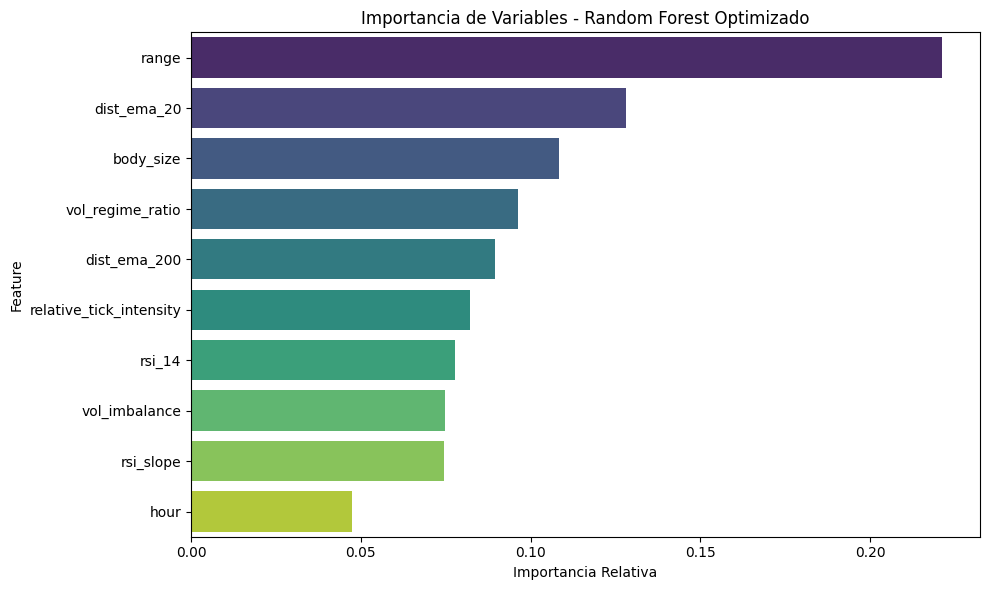

In [102]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
importances = best_rf.feature_importances_
feature_names = X_train.columns
rf_feat_imp = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)
print("\n=== TOP 10 FEATURES (Random Forest Final) ===")
print(rf_feat_imp.head(10).to_string(index=False))
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=rf_feat_imp.head(10), palette='viridis')
plt.title('Importancia de Variables - Random Forest Optimizado')
plt.xlabel('Importancia Relativa')
plt.tight_layout()
plt.show()


# Cat


=== TOP 10 FEATURES (CatBoost Final) ===
                Feature  Importance
                  range   21.993188
       vol_regime_ratio   11.331834
            dist_ema_20   10.744766
                   hour   10.068180
              body_size    9.858559
           dist_ema_200    8.163557
          vol_imbalance    7.620254
              rsi_slope    7.433137
                 rsi_14    6.985062
relative_tick_intensity    5.801465


/var/folders/l8/j7p44fhj15l57k7pck7kcm340000gn/T/ipykernel_7594/1388350110.py:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=cb_feat_imp.head(10), palette='magma')


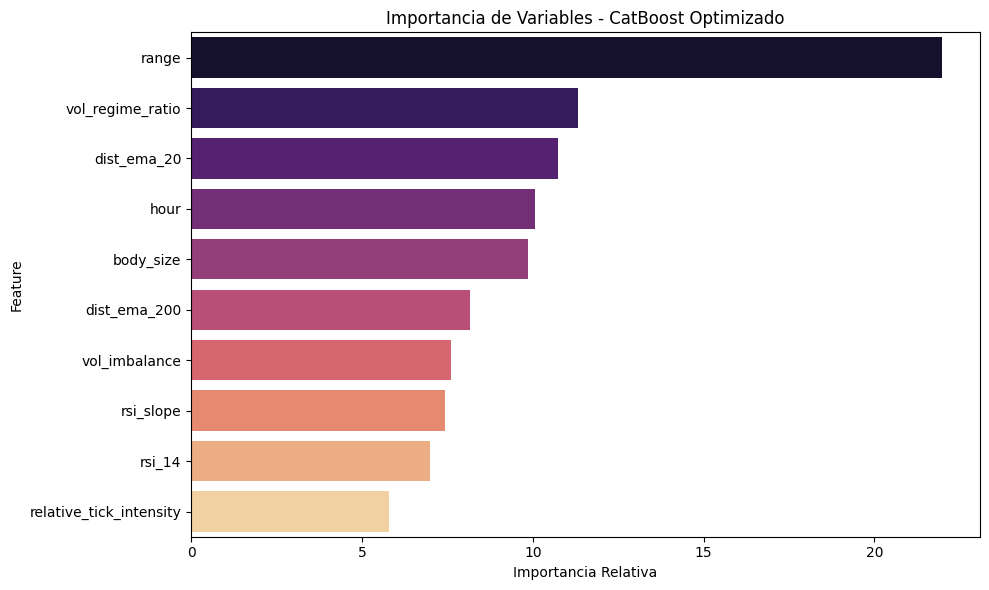

In [103]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
importances = best_cb.feature_importances_
feature_names = X_train.columns
cb_feat_imp = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)
print("\n=== TOP 10 FEATURES (CatBoost Final) ===")
print(cb_feat_imp.head(10).to_string(index=False))
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=cb_feat_imp.head(10), palette='magma')
plt.title('Importancia de Variables - CatBoost Optimizado')
plt.xlabel('Importancia Relativa')
plt.tight_layout()
plt.show()


# Validacion nuevos datos

# Features nuevos datos

## ETIQUETA

In [ ]:
import polars as pl
PATH_TRADES_OOS = 'test_results_M3_final.csv'
def load_oos_labels(path):
    print(f">>> Cargando etiquetas de validación OOS desde: {path}")
    df_raw = pl.read_csv(path)
    time_cols = ['signal_ts', 'entry_ts_real', 'exit_price_ts']
    df_processed = (
        df_raw
        .filter(pl.col('signal') == -1) 
        .with_columns([
            pl.col(col).str.to_datetime().cast(pl.Datetime('ms')) 
            for col in time_cols
        ])
    )
    keep_cols_oos = [
        'signal_ts', 
        'target_15p', 
        'pnl_pips_net', 
        'mae_pips', 
        'mfe_pips', 
        'exit_reason'
    ]
    df_labels_oos = (
        df_processed
        .filter(pl.col('entry_allowed') == True)
        .select(keep_cols_oos)
        .drop_nulls(subset=['target_15p'])
        .with_columns(pl.col('target_15p').cast(pl.Int8))
    )
    print(f"✅ Etiquetas OOS cargadas. Shape: {df_labels_oos.shape}")
    return df_labels_oos
df_ml_labels_oos = load_oos_labels(PATH_TRADES_OOS)
print("\nVista previa de etiquetas OOS:")
print(df_ml_labels_oos.head())


>>> Cargando etiquetas de validación OOS desde: /Users/rjsaavedra/Documents/Projects/ml_master_project/src/test_results_M3_final.csv
✅ Etiquetas OOS cargadas. Shape: (167, 6)

Vista previa de etiquetas OOS:
shape: (5, 6)
┌─────────────────────┬────────────┬──────────────┬──────────┬──────────┬─────────────┐
│ signal_ts           ┆ target_15p ┆ pnl_pips_net ┆ mae_pips ┆ mfe_pips ┆ exit_reason │
│ ---                 ┆ ---        ┆ ---          ┆ ---      ┆ ---      ┆ ---         │
│ datetime[ms]        ┆ i8         ┆ f64          ┆ f64      ┆ f64      ┆ str         │
╞═════════════════════╪════════════╪══════════════╪══════════╪══════════╪═════════════╡
│ 2025-07-01 12:51:00 ┆ 1          ┆ 7.8          ┆ 33.5     ┆ 20.1     ┆ TP          │
│ 2025-07-01 13:33:00 ┆ 1          ┆ 10.15        ┆ 6.35     ┆ 45.7     ┆ TP          │
│ 2025-07-05 15:18:00 ┆ 0          ┆ -2.4         ┆ 5.0      ┆ 6.4      ┆ TIME        │
│ 2025-07-06 09:24:00 ┆ 0          ┆ -10.4        ┆ 30.5     ┆ 1.4      ┆ S

# Features

In [105]:
import polars as pl
from datetime import date
df_combined_m3 = pl.concat([df_train_m3, df_test_m3])
df_features_full = calculate_ml_features(df_combined_m3)
split_date_oos = date(2025, 7, 1)
df_features_oos = df_features_full.filter(pl.col("ts").dt.date() >= split_date_oos)
df_final_ml_oos = (
    df_features_oos.rename({"ts": "signal_ts"})
    .join(df_ml_labels_oos, on="signal_ts", how="inner")
)
print(f"\n>>> [DATASET VALIDACIÓN OOS] Listo")
print(f"Registros OOS con señal y features: {df_final_ml_oos.height}")
print(df_final_ml_oos.head())


>>> Calculando Features para ML...
✅ Features calculadas. Columnas totales: 23

>>> [DATASET VALIDACIÓN OOS] Listo
Registros OOS con señal y features: 167
shape: (5, 28)
┌─────────────┬──────────┬──────────┬──────────┬───┬────────────┬──────────┬──────────┬────────────┐
│ signal_ts   ┆ open     ┆ high     ┆ low      ┆ … ┆ pnl_pips_n ┆ mae_pips ┆ mfe_pips ┆ exit_reaso │
│ ---         ┆ ---      ┆ ---      ┆ ---      ┆   ┆ et         ┆ ---      ┆ ---      ┆ n          │
│ datetime[ms ┆ f64      ┆ f64      ┆ f64      ┆   ┆ ---        ┆ f64      ┆ f64      ┆ ---        │
│ ]           ┆          ┆          ┆          ┆   ┆ f64        ┆          ┆          ┆ str        │
╞═════════════╪══════════╪══════════╪══════════╪═══╪════════════╪══════════╪══════════╪════════════╡
│ 2025-07-01  ┆ 1.15394  ┆ 1.15578  ┆ 1.153525 ┆ … ┆ 7.8        ┆ 33.5     ┆ 20.1     ┆ TP         │
│ 12:51:00    ┆          ┆          ┆          ┆   ┆            ┆          ┆          ┆            │
│ 2025-07-01  ┆ 1.1570

# Baseline 

In [106]:
import polars as pl
import numpy as np
def calculate_strategy_metrics(df, name=""):
    df_exec = df.filter(pl.col("pnl_pips_net").is_not_null())
    if df_exec.height == 0: 
        print(f"--- {name}: No hay trades ejecutados ---")
        return None
    n_trades = df_exec.height
    n_win = df_exec.filter(pl.col("pnl_pips_net") > 0).height
    win_rate = (n_win / n_trades) * 100
    total_return_pips = df_exec["pnl_pips_net"].sum()
    avg_return_pips = df_exec["pnl_pips_net"].mean() 
    equity = df_exec["pnl_pips_net"].to_numpy().cumsum()
    high_water_mark = np.maximum.accumulate(equity)
    drawdowns = high_water_mark - equity
    max_dd_pips = np.max(drawdowns) if len(drawdowns) > 0 else 0
    print(f"--- {name} Baseline Metrics ---")
    print(f"Trades Totales: {n_trades}")
    print(f"Win Rate:       {win_rate:.2f}%")
    print(f"Esperanza:      {avg_return_pips:.2f} pips/trade")
    print(f"Retorno Total:  {total_return_pips:.2f} pips")
    print(f"Max Drawdown:   {max_dd_pips:.2f} pips")
    print("-" * 30)
    return {
        "trades": n_trades, "win_rate": win_rate, "expectancy": avg_return_pips,
        "total_return": total_return_pips, "max_dd": max_dd_pips
    }
print("Calculando Baselines del Sistema...")
metrics_train_base = calculate_strategy_metrics(df_final_ml, "TRAIN (2021-2025)")
metrics_test_base = calculate_strategy_metrics(df_final_ml_oos, "TEST OOS (Jul-Nov 2025)")


Calculando Baselines del Sistema...
--- TRAIN (2021-2025) Baseline Metrics ---
Trades Totales: 1673
Win Rate:       52.00%
Esperanza:      -0.24 pips/trade
Retorno Total:  -405.05 pips
Max Drawdown:   481.60 pips
------------------------------
--- TEST OOS (Jul-Nov 2025) Baseline Metrics ---
Trades Totales: 167
Win Rate:       52.10%
Esperanza:      -0.10 pips/trade
Retorno Total:  -16.55 pips
Max Drawdown:   143.65 pips
------------------------------


# Ml prueba

In [107]:
import pandas as pd
import numpy as np
from sklearn.metrics import roc_auc_score, precision_score
features_cols = [
    'range', 'body_size', 'rsi_14', 'rsi_slope', 'dist_ema_20', 
    'dist_ema_200', 'vol_regime_ratio', 'vol_imbalance', 
    'relative_tick_intensity', 'hour'
]
X_oos = df_final_ml_oos.select(features_cols).to_pandas()
y_oos = df_final_ml_oos.select('target_15p').to_pandas().values.ravel()
pnl_oos = df_final_ml_oos.select('pnl_pips_net').to_pandas().values.ravel()
dates_oos = pd.to_datetime(df_final_ml_oos.select('signal_ts').to_pandas()['signal_ts'])
threshold_rf = 0.25
threshold_cb = 0.25 
monthly_stats = []
for month in sorted(dates_oos.dt.to_period('M').unique()):
    mask = (dates_oos.dt.to_period('M') == month)
    X_m = X_oos[mask]
    y_m = y_oos[mask]
    pnl_m = pnl_oos[mask]
    if len(y_m) == 0: continue
    probs_rf = best_rf.predict_proba(X_m)[:, 1]
    preds_rf = (probs_rf >= threshold_rf).astype(int)
    probs_cb = best_cb.predict_proba(X_m)[:, 1]
    preds_cb = (probs_cb >= threshold_cb).astype(int)
    pips_rf = pnl_m[preds_rf == 1].sum()
    pips_cb = pnl_m[preds_cb == 1].sum()
    monthly_stats.append({
        'Mes': str(month),
        'Signals_RF': sum(preds_rf),
        'Prec_RF': precision_score(y_m, preds_rf, zero_division=0),
        'Pips_RF': round(pips_rf, 1),
        'Signals_CB': sum(preds_cb),
        'Prec_CB': precision_score(y_m, preds_cb, zero_division=0),
        'Pips_CB': round(pips_cb, 1),
        'AUC_CB': roc_auc_score(y_m, probs_cb) if len(np.unique(y_m)) > 1 else 0.5
    })
df_results = pd.DataFrame(monthly_stats)
print("\n" + "="*80)
print(f"{'RESUMEN DE VALIDACIÓN FUERA DE MUESTRA (JUL-NOV 2025)':^80}")
print("="*80)
print(df_results.to_string(index=False))
print("\n" + "="*80)
print(f"TOTAL PIPS RF: {df_results['Pips_RF'].sum():.1f} | TOTAL PIPS CB: {df_results['Pips_CB'].sum():.1f}")
print("="*80)



             RESUMEN DE VALIDACIÓN FUERA DE MUESTRA (JUL-NOV 2025)              
    Mes  Signals_RF  Prec_RF  Pips_RF  Signals_CB  Prec_CB  Pips_CB   AUC_CB
2025-07          33 0.363636     44.1          26 0.423077     64.9 0.594406
2025-08          32 0.343750      7.2          24 0.375000    -20.7 0.493506
2025-09          43 0.209302     -4.8          32 0.281250     -8.0 0.699346
2025-10          23 0.260870    -51.4          16 0.312500    -22.3 0.527778
2025-11          32 0.250000    -15.7          17 0.411765     29.2 0.810000

TOTAL PIPS RF: -20.6 | TOTAL PIPS CB: 43.1


# Catboost

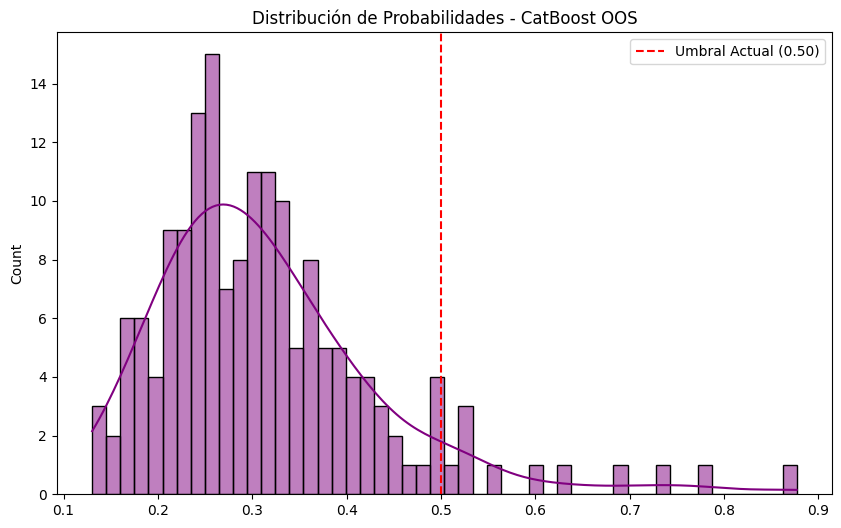

Señales con umbral 0.50: 13
Señales con umbral 0.45: 17


In [109]:
import seaborn as sns
import matplotlib.pyplot as plt
probs_oos = best_cb.predict_proba(X_oos)[:, 1]
plt.figure(figsize=(10, 6))
sns.histplot(probs_oos, bins=50, kde=True, color='purple')
plt.axvline(0.50, color='red', linestyle='--', label='Umbral Actual (0.50)')
plt.title('Distribución de Probabilidades - CatBoost OOS')
plt.legend()
plt.show()
print(f"Señales con umbral 0.50: {sum(probs_oos >= 0.50)}")
print(f"Señales con umbral 0.45: {sum(probs_oos >= 0.45)}")


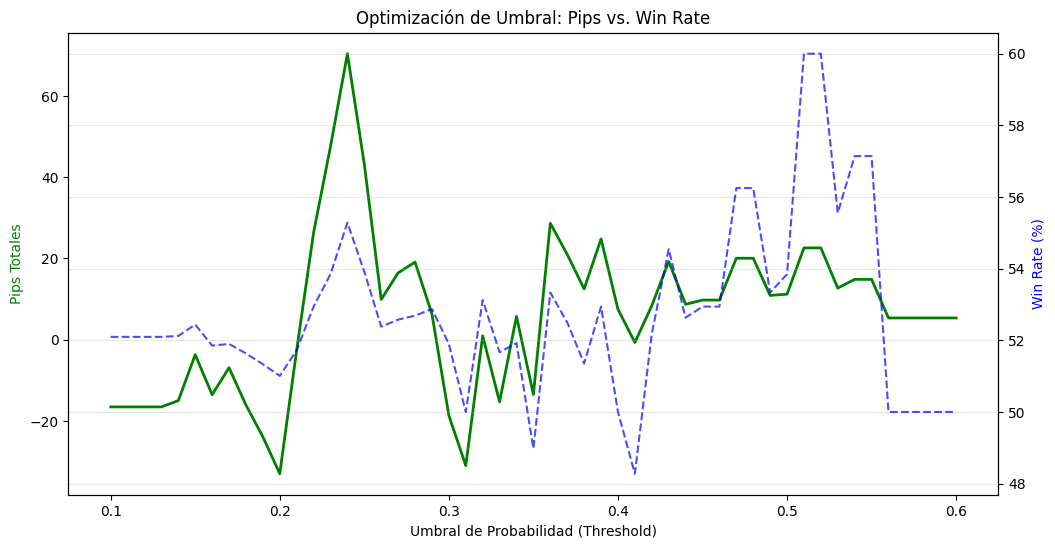

    threshold  total_pips   win_rate  trades  max_dd  pips_per_trade
14       0.24       70.40  55.284553     123   98.90        0.572358
13       0.23       47.55  53.846154     130  108.65        0.365769
15       0.25       43.20  53.913043     115   97.75        0.375652
26       0.36       28.65  53.333333      45   47.15        0.636667
12       0.22       26.35  52.941176     136  108.65        0.193750
29       0.39       24.80  52.941176      34   44.95        0.729412
41       0.51       22.60  60.000000      10   20.80        2.260000
42       0.52       22.60  60.000000      10   20.80        2.260000
27       0.37       21.00  52.500000      40   66.00        0.525000
38       0.48       20.05  56.250000      16   32.60        1.253125


In [110]:
import pandas as pd
import matplotlib.pyplot as plt
def optimize_threshold(df_oos, model):
    features_list = ['range', 'body_size', 'rsi_14', 'rsi_slope', 'dist_ema_20', 
                     'dist_ema_200', 'vol_regime_ratio', 'vol_imbalance', 
                     'relative_tick_intensity', 'hour']
    X_oos = df_oos.select(features_list).to_pandas()
    probs = model.predict_proba(X_oos)[:, 1]
    df_analysis = df_oos.with_columns(pl.Series(name="ml_prob", values=probs)).to_pandas()
    thresholds = np.arange(0.10, 0.61, 0.01)
    results = []
    for t in thresholds:
        filtered = df_analysis[df_analysis["ml_prob"] >= t]
        if len(filtered) < 5: continue 
        pips = filtered["pnl_pips_net"].sum()
        win_rate = (filtered["pnl_pips_net"] > 0).mean() * 100
        equity = filtered["pnl_pips_net"].cumsum()
        max_dd = (equity.cummax() - equity).max()
        results.append({
            "threshold": round(t, 2),
            "total_pips": pips,
            "win_rate": win_rate,
            "trades": len(filtered),
            "max_dd": max_dd,
            "pips_per_trade": pips / len(filtered)
        })
    return pd.DataFrame(results)
df_opt = optimize_threshold(df_final_ml_oos, best_cb)
fig, ax1 = plt.subplots(figsize=(12, 6))
ax2 = ax1.twinx()
ax1.plot(df_opt["threshold"], df_opt["total_pips"], 'g-', label="Pips Totales", linewidth=2)
ax2.plot(df_opt["threshold"], df_opt["win_rate"], 'b--', label="Win Rate (%)", alpha=0.7)
ax1.set_xlabel('Umbral de Probabilidad (Threshold)')
ax1.set_ylabel('Pips Totales', color='g')
ax2.set_ylabel('Win Rate (%)', color='b')
plt.title('Optimización de Umbral: Pips vs. Win Rate')
plt.grid(True, alpha=0.3)
plt.show()
print(df_opt.sort_values(by="total_pips", ascending=False).head(10))


In [111]:
def filter_and_save_trades_shorts(df_oos, model, threshold=0.24, model_name="CatBoost (Shorts)", save_path="catboost_trades_shorts_024.csv"):
    print(f"\nFiltrando trades con {model_name} (Umbral: {threshold})...")
    features_list = [
        'range', 'body_size', 'rsi_14', 'rsi_slope', 'dist_ema_20', 
        'dist_ema_200', 'vol_regime_ratio', 'vol_imbalance', 
        'relative_tick_intensity', 'hour'
    ]
    X_oos = df_oos.select(features_list).to_pandas()
    probs = model.predict_proba(X_oos)[:, 1]
    df_filtered = df_oos.with_columns(pl.Series(name="ml_prob", values=probs))
    df_filtered = df_filtered.filter(pl.col("ml_prob") >= threshold)
    df_filtered.write_csv(save_path)
    print(f"✅ Trades guardados exitosamente en: {save_path}")
    print(f"   Total trades seleccionados: {df_filtered.height}")
    if "pnl_pips_net" in df_filtered.columns:
        calculate_strategy_metrics(df_filtered, f"{model_name} Filtered (Th={threshold})")
    return df_filtered
df_catboost_shorts = filter_and_save_trades_shorts(
    df_final_ml_oos, 
    best_cb, 
    threshold=0.24, 
    model_name="CatBoost Shorts", 
    save_path="catboost_trades_shorts_024.csv"
)
print(df_catboost_shorts.head())



Filtrando trades con CatBoost Shorts (Umbral: 0.24)...
✅ Trades guardados exitosamente en: catboost_trades_shorts_024.csv
   Total trades seleccionados: 123
--- CatBoost Shorts Filtered (Th=0.24) Baseline Metrics ---
Trades Totales: 123
Win Rate:       55.28%
Esperanza:      0.57 pips/trade
Retorno Total:  70.40 pips
Max Drawdown:   98.90 pips
------------------------------
shape: (5, 29)
┌──────────────┬──────────┬──────────┬──────────┬───┬──────────┬──────────┬─────────────┬──────────┐
│ signal_ts    ┆ open     ┆ high     ┆ low      ┆ … ┆ mae_pips ┆ mfe_pips ┆ exit_reason ┆ ml_prob  │
│ ---          ┆ ---      ┆ ---      ┆ ---      ┆   ┆ ---      ┆ ---      ┆ ---         ┆ ---      │
│ datetime[ms] ┆ f64      ┆ f64      ┆ f64      ┆   ┆ f64      ┆ f64      ┆ str         ┆ f64      │
╞══════════════╪══════════╪══════════╪══════════╪═══╪══════════╪══════════╪═════════════╪══════════╡
│ 2025-07-01   ┆ 1.15394  ┆ 1.15578  ┆ 1.153525 ┆ … ┆ 33.5     ┆ 20.1     ┆ TP          ┆ 0.876937 │
│

# Random

Probabilidad Mínima: 0.2205
Probabilidad Máxima: 0.8747
Probabilidad Promedio: 0.4284


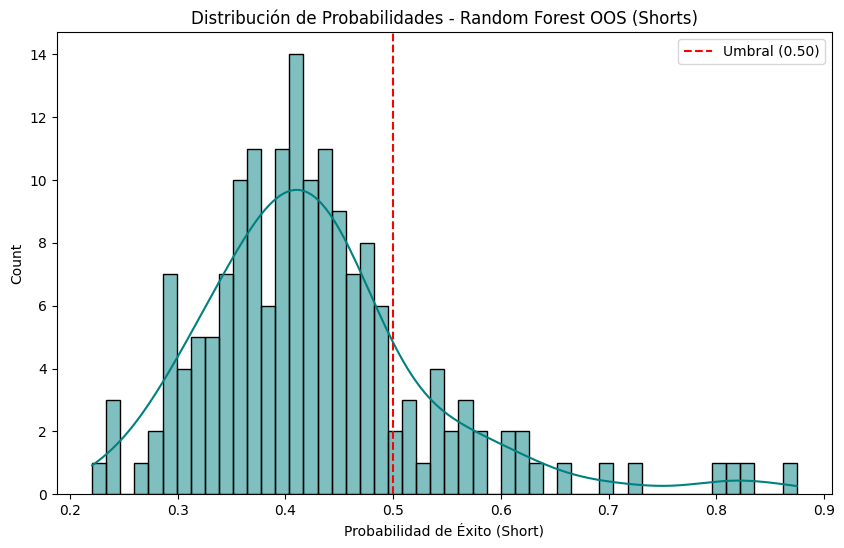

Señales RF con umbral 0.50: 27
Señales RF con umbral 0.45: 55


In [113]:
import seaborn as sns
import matplotlib.pyplot as plt
features_list = [
    'range', 'body_size', 'rsi_14', 'rsi_slope', 'dist_ema_20', 
    'dist_ema_200', 'vol_regime_ratio', 'vol_imbalance', 
    'relative_tick_intensity', 'hour'
]
X_oos_rf = df_final_ml_oos.select(features_list).to_pandas()
probs_rf_oos = best_rf.predict_proba(X_oos_rf)[:, 1]
print(f"Probabilidad Mínima: {probs_rf_oos.min():.4f}")
print(f"Probabilidad Máxima: {probs_rf_oos.max():.4f}")
print(f"Probabilidad Promedio: {probs_rf_oos.mean():.4f}")
plt.figure(figsize=(10, 6))
sns.histplot(probs_rf_oos, bins=50, kde=True, color='teal')
plt.axvline(0.50, color='red', linestyle='--', label='Umbral (0.50)')
plt.title('Distribución de Probabilidades - Random Forest OOS (Shorts)')
plt.xlabel('Probabilidad de Éxito (Short)')
plt.legend()
plt.show()
print(f"Señales RF con umbral 0.50: {sum(probs_rf_oos >= 0.50)}")
print(f"Señales RF con umbral 0.45: {sum(probs_rf_oos >= 0.45)}")


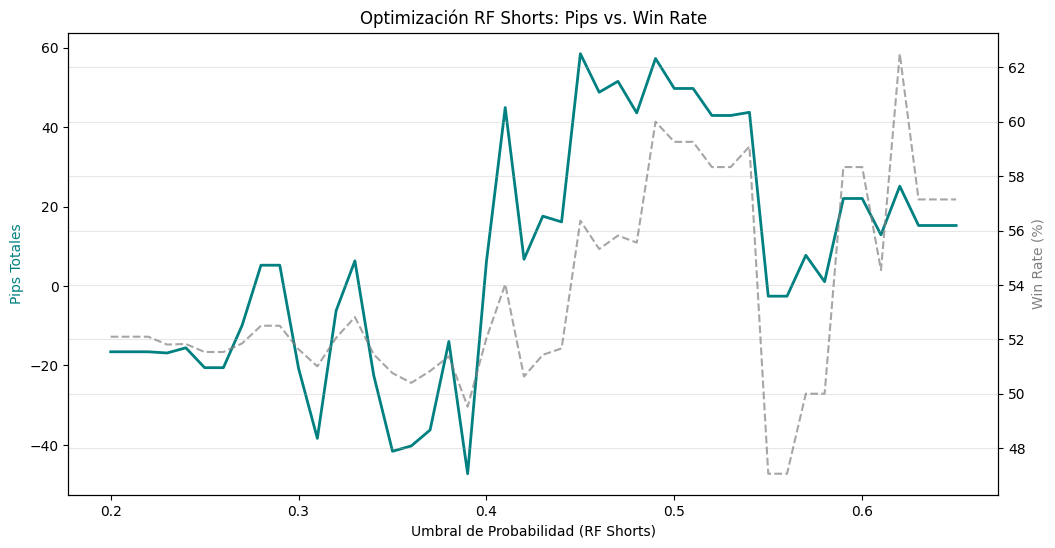

    threshold  total_pips   win_rate  trades  max_dd  pips_per_trade
25       0.45       58.50  56.363636      55   60.55        1.063636
29       0.49       57.30  60.000000      30   44.65        1.910000
27       0.47       51.55  55.813953      43   48.50        1.198837
31       0.51       49.75  59.259259      27   43.35        1.842593
30       0.50       49.75  59.259259      27   43.35        1.842593
26       0.46       48.80  55.319149      47   48.50        1.038298
21       0.41       44.95  54.022989      87   85.00        0.516667
34       0.54       43.75  59.090909      22   32.60        1.988636
28       0.48       43.60  55.555556      36   56.65        1.211111
32       0.52       42.95  58.333333      24   32.50        1.789583


In [114]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import polars as pl
def optimize_threshold_rf_shorts(df_oos, model):
    features_list = [
        'range', 'body_size', 'rsi_14', 'rsi_slope', 'dist_ema_20', 
        'dist_ema_200', 'vol_regime_ratio', 'vol_imbalance', 
        'relative_tick_intensity', 'hour'
    ]
    X_oos = df_oos.select(features_list).to_pandas()
    probs = model.predict_proba(X_oos)[:, 1]
    df_analysis = df_oos.with_columns(pl.Series(name="ml_prob", values=probs)).to_pandas()
    thresholds = np.arange(0.20, 0.66, 0.01)
    results = []
    for t in thresholds:
        filtered = df_analysis[df_analysis["ml_prob"] >= t]
        if len(filtered) < 5: continue 
        pips = filtered["pnl_pips_net"].sum()
        win_rate = (filtered["pnl_pips_net"] > 0).mean() * 100 if len(filtered) > 0 else 0
        equity = filtered["pnl_pips_net"].cumsum()
        max_dd = (equity.cummax() - equity).max() if len(equity) > 0 else 0
        results.append({
            "threshold": round(t, 2),
            "total_pips": pips,
            "win_rate": win_rate,
            "trades": len(filtered),
            "max_dd": max_dd,
            "pips_per_trade": pips / len(filtered) if len(filtered) > 0 else 0
        })
    return pd.DataFrame(results)
df_opt_rf = optimize_threshold_rf_shorts(df_final_ml_oos, best_rf)
fig, ax1 = plt.subplots(figsize=(12, 6))
ax2 = ax1.twinx()
ax1.plot(df_opt_rf["threshold"], df_opt_rf["total_pips"], 'teal', label="Pips Totales (RF)", linewidth=2)
ax2.plot(df_opt_rf["threshold"], df_opt_rf["win_rate"], 'gray', linestyle='--', label="Win Rate %", alpha=0.7)
ax1.set_xlabel('Umbral de Probabilidad (RF Shorts)')
ax1.set_ylabel('Pips Totales', color='teal')
ax2.set_ylabel('Win Rate (%)', color='gray')
plt.title('Optimización RF Shorts: Pips vs. Win Rate')
plt.grid(True, alpha=0.3)
plt.show()
print(df_opt_rf.sort_values(by="total_pips", ascending=False).head(10))


In [115]:
def filter_and_save_trades_rf_shorts(df_oos, model, threshold=0.41, model_name="RandomForest (Shorts)", save_path="rf_trades_shorts_041.csv"):
    print(f"\nFiltrando trades con {model_name} (Umbral: {threshold})...")
    features_list = [
        'range', 'body_size', 'rsi_14', 'rsi_slope', 'dist_ema_20', 
        'dist_ema_200', 'vol_regime_ratio', 'vol_imbalance', 
        'relative_tick_intensity', 'hour'
    ]
    X_oos = df_oos.select(features_list).to_pandas()
    probs = model.predict_proba(X_oos)[:, 1]
    df_filtered = df_oos.with_columns(pl.Series(name="ml_prob", values=probs))
    df_filtered = df_filtered.filter(pl.col("ml_prob") >= threshold)
    df_filtered.write_csv(save_path)
    print(f"✅ Trades guardados exitosamente en: {save_path}")
    print(f"   Total trades seleccionados: {df_filtered.height}")
    if "pnl_pips_net" in df_filtered.columns:
        calculate_strategy_metrics(df_filtered, f"{model_name} Filtered (Th={threshold})")
    return df_filtered
df_rf_shorts_032 = filter_and_save_trades_rf_shorts(
    df_final_ml_oos, 
    best_rf, 
    threshold=0.41, 
    model_name="RandomForest (Shorts)", 
    save_path="rf_trades_shorts_041.csv"
)
print(df_rf_shorts_032.head())



Filtrando trades con RandomForest (Shorts) (Umbral: 0.41)...
✅ Trades guardados exitosamente en: rf_trades_shorts_041.csv
   Total trades seleccionados: 87
--- RandomForest (Shorts) Filtered (Th=0.41) Baseline Metrics ---
Trades Totales: 87
Win Rate:       54.02%
Esperanza:      0.52 pips/trade
Retorno Total:  44.95 pips
Max Drawdown:   85.00 pips
------------------------------
shape: (5, 29)
┌──────────────┬──────────┬──────────┬──────────┬───┬──────────┬──────────┬─────────────┬──────────┐
│ signal_ts    ┆ open     ┆ high     ┆ low      ┆ … ┆ mae_pips ┆ mfe_pips ┆ exit_reason ┆ ml_prob  │
│ ---          ┆ ---      ┆ ---      ┆ ---      ┆   ┆ ---      ┆ ---      ┆ ---         ┆ ---      │
│ datetime[ms] ┆ f64      ┆ f64      ┆ f64      ┆   ┆ f64      ┆ f64      ┆ str         ┆ f64      │
╞══════════════╪══════════╪══════════╪══════════╪═══╪══════════╪══════════╪═════════════╪══════════╡
│ 2025-07-01   ┆ 1.15394  ┆ 1.15578  ┆ 1.153525 ┆ … ┆ 33.5     ┆ 20.1     ┆ TP          ┆ 0.874693